# Draw the Mandelbrot Set in Python

by Bartosz Zaczyński  Jan 31, 2022 
https://realpython.com/mandelbrot-set-python/

with additions and tests from myke, 2022-01-31

In [1]:
# all imports 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from PIL.ImageColor import getrgb
from dataclasses import dataclass
from math import log
import matplotlib.cm
from scipy.interpolate import interp1d

**Understanding the Mandelbrot Set**

In [2]:
# testing
def z(n, c):
    if n == 0:
        return 0
    else:
        return z(n - 1, c) ** 2 + c

In [3]:
for n in range(10):
    print(f"z({n}) = {z(n, c=1)}")

z(0) = 0
z(1) = 1
z(2) = 2
z(3) = 5
z(4) = 26
z(5) = 677
z(6) = 458330
z(7) = 210066388901
z(8) = 44127887745906175987802
z(9) = 1947270476915296449559703445493848930452791205


In [4]:
def sequence(c):
    z = 0
    while True:
        yield z
        z = z ** 2 + c

In [5]:
for n, z in enumerate(sequence(c=1)):
    print(f"z({n}) = {z}")
    if n >= 9:
        break

z(0) = 0
z(1) = 1
z(2) = 2
z(3) = 5
z(4) = 26
z(5) = 677
z(6) = 458330
z(7) = 210066388901
z(8) = 44127887745906175987802
z(9) = 1947270476915296449559703445493848930452791205


In [6]:
def sequence(c, z=0):
    while True:
        yield z
        z = z ** 2 + c

In [7]:
# wrappers
def mandelbrot(candidate):
    return sequence(z=0, c=candidate)

def julia(candidate, parameter):
    return sequence(z=candidate, c=parameter)

**Plotting the Mandelbrot Set Using Python’s Matplotlib**

In [8]:
def complex_matrix(xmin, xmax, ymin, ymax, pixel_density):
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

In [9]:
def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2

In [10]:
# tuning
np.warnings.filterwarnings("ignore")

*Low-Resolution Scatter Plot*

In [11]:
def get_members(c, num_iterations):
    mask = is_stable(c, num_iterations)
    return c[mask]

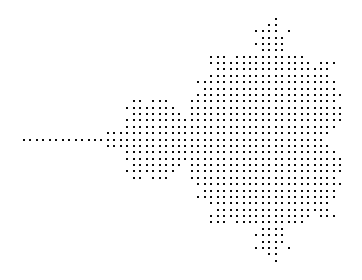

In [12]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=21)
members = get_members(c, num_iterations=20)

plt.scatter(members.real, members.imag, color="black", marker=",", s=1)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

*High-Resolution Black-and-White Visualization*

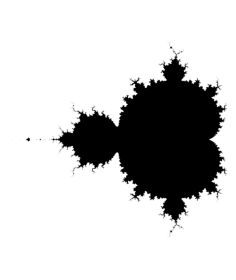

In [13]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
plt.imshow(is_stable(c, num_iterations=20), cmap="binary")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

**Drawing the Mandelbrot Set With Pillow**

In [14]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
image = Image.fromarray(~is_stable(c, num_iterations=20))
image.show()

In [15]:
# builtin
Image.effect_mandelbrot((512, 512), (-3, -2.5, 2, 2.5), 100).show()

*Finding Convergent Elements of the Set*

In [16]:
def is_stable(c, max_iterations):
    z = 0
    for _ in range(max_iterations):
        z = z ** 2 + c
        if abs(z) > 2:
            return False
    return True

In [18]:
# test it
print(is_stable(0.26, max_iterations=20))
print(is_stable(0.26, max_iterations=30))

True
False


In [19]:
# mandelbrot.py

@dataclass
class MandelbrotSet:
    max_iterations: int

    def __contains__(self, c: complex) -> bool:
        z = 0
        for _ in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return False
        return True

In [21]:
# test 
mandelbrot_set = MandelbrotSet(max_iterations=30)
print(0.26 in mandelbrot_set)
print(0.26 not in mandelbrot_set)

False
True


In [22]:
mandelbrot_set = MandelbrotSet(max_iterations=20)

width, height = 512, 512
scale = 0.0075
BLACK_AND_WHITE = "1"

from PIL import Image
image = Image.new(mode=BLACK_AND_WHITE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 2, height / 2 - y)
        image.putpixel((x, y), c not in mandelbrot_set)

image.show()

*Measuring Divergence With the Escape Count*

In [23]:
@dataclass
class MandelbrotSet:
    max_iterations: int

    def escape_count(self, c: complex) -> int:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return iteration
        return self.max_iterations

In [24]:
@dataclass
class MandelbrotSet:
    max_iterations: int

    def stability(self, c: complex) -> float:
        return self.escape_count(c) / self.max_iterations

    def escape_count(self, c: complex) -> int:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return iteration
        return self.max_iterations

In [25]:
@dataclass
class MandelbrotSet:
    max_iterations: int

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex) -> float:
        return self.escape_count(c) / self.max_iterations

    def escape_count(self, c: complex) -> int:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return iteration
        return self.max_iterations

In [26]:
# tests
mandelbrot_set = MandelbrotSet(max_iterations=30)

print(mandelbrot_set.escape_count(0.25))

print(mandelbrot_set.stability(0.25))

print(0.25 in mandelbrot_set)

print(mandelbrot_set.escape_count(0.26))

print(mandelbrot_set.stability(0.26))

print(0.26 in mandelbrot_set)

30
1.0
True
29
0.9666666666666667
False


In [27]:
# more
mandelbrot_set = MandelbrotSet(max_iterations=20)

width, height = 512, 512
scale = 0.0075
GRAYSCALE = "L"

from PIL import Image
image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 2, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c)
        image.putpixel((x, y), int(instability * 255))

image.show()

*Smoothing Out the Banding Artifacts*

In [35]:
@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex, smooth=False) -> float:
        return self.escape_count(c, smooth) / self.max_iterations

    def escape_count(self, c: complex, smooth=False) :
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations

In [36]:
# tests
mandelbrot_set = MandelbrotSet(max_iterations=30)

print(mandelbrot_set.stability(-1.2039 - 0.1996j, smooth=True))
print(mandelbrot_set.stability(42, smooth=True))

1.014794475165942
-0.030071301713066417


In [37]:
@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex, smooth=False, clamp=True) -> float:
        value = self.escape_count(c, smooth) / self.max_iterations
        return max(0.0, min(value, 1.0)) if clamp else value

    def escape_count(self, c: complex, smooth=False) :
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations

In [38]:
# test
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)

width, height = 512, 512
scale = 0.0075
GRAYSCALE = "L"

from PIL import Image
image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 2, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c, smooth=True)
        image.putpixel((x, y), int(instability * 255))

image.show()

*Translating Between Set Elements and Pixels*

In [40]:
@dataclass
class Viewport:
    image: Image.Image
    center: complex
    width: float

    @property
    def height(self):
        return self.scale * self.image.height

    @property
    def offset(self):
        return self.center + complex(-self.width, self.height) / 2

    @property
    def scale(self):
        return self.width / self.image.width

    def __iter__(self):
        for y in range(self.image.height):
            for x in range(self.image.width):
                yield Pixel(self, x, y)

In [42]:
@dataclass
class Pixel:
    viewport: Viewport
    x: int
    y: int

    @property
    def color(self):
        return self.viewport.image.getpixel((self.x, self.y))

    @color.setter
    def color(self, value):
        self.viewport.image.putpixel((self.x, self.y), value)

    def __complex__(self):
        return (
                complex(self.x, -self.y)
                * self.viewport.scale
                + self.viewport.offset
        )

In [43]:
mandelbrot_set = MandelbrotSet(max_iterations=20)

image = Image.new(mode="1", size=(512, 512), color=1)
for pixel in Viewport(image, center=-0.75, width=3.5):
    if complex(pixel) in mandelbrot_set:
        pixel.color = 0

image.show()

In [44]:
mandelbrot_set = MandelbrotSet(max_iterations=256, escape_radius=1000)

image = Image.new(mode="L", size=(512, 512))
for pixel in Viewport(image, center=-0.7435 + 0.1314j, width=0.002):
    c = complex(pixel)
    instability = 1 - mandelbrot_set.stability(c, smooth=True)
    pixel.color = int(instability * 255)

image.show()

In [45]:
enhancer = ImageEnhance.Brightness(image)
enhancer.enhance(1.25).show()

**Making an Artistic Representation of the Mandelbrot Set**

In [46]:
image = Image.new(mode="RGB", size=(width, height))

In [47]:
def paint(mandelbrot_set, viewport, palette, smooth):
    for pixel in viewport:
        stability = mandelbrot_set.stability(complex(pixel), smooth)
        index = int(min(stability * len(palette), len(palette) - 1))
        pixel.color = palette[index % len(palette)]

In [48]:
def denormalize(palette):
    return [
        tuple(int(channel * 255) for channel in color)
        for color in palette
    ]

In [49]:
colormap = matplotlib.cm.get_cmap("twilight").colors
palette = denormalize(colormap)

print(len(colormap))

print(colormap[0])

print(palette[0])

510
[0.8857501584075443, 0.8500092494306783, 0.8879736506427196]
(225, 216, 226)


In [50]:
mandelbrot_set = MandelbrotSet(max_iterations=512, escape_radius=1000)
image = Image.new(mode="RGB", size=(512, 512))
viewport = Viewport(image, center=-0.7435 + 0.1314j, width=0.002)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

In [51]:
exterior = [(1, 1, 1)] * 50
interior = [(1, 1, 1)] * 5
gray_area = [(1 - i / 44,) * 3 for i in range(45)]
palette = denormalize(exterior + gray_area + interior)

In [52]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
viewport = Viewport(image, center=-0.75, width=3.5)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

*Color Gradient*

In [53]:
def make_gradient(colors, interpolation="linear"):
    X = [i / (len(colors) - 1) for i in range(len(colors))]
    Y = [[color[i] for color in colors] for i in range(3)]
    channels = [interp1d(X, y, kind=interpolation) for y in Y]
    return lambda x: [np.clip(channel(x), 0, 1) for channel in channels]

In [54]:
black = (0, 0, 0)
blue = (0, 0, 1)
maroon = (0.5, 0, 0)
navy = (0, 0, 0.5)
red = (1, 0, 0)

colors = [black, navy, blue, maroon, red, black]
gradient = make_gradient(colors, interpolation="cubic")

gradient(0.42)

[0.026749999999999954, 0.0, 0.9435000000000001]

In [55]:
num_colors = 256
palette = denormalize([
    gradient(i / num_colors) for i in range(num_colors)
])

len(palette), palette[127]

(256, (46, 0, 143))

In [56]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
paint(mandelbrot_set, viewport, palette, smooth=True)
image.show()

*Color Model*

In [57]:
def hsb(hue_degrees: int, saturation: float, brightness: float):
    return getrgb(
        f"hsv({hue_degrees % 360},"
        f"{saturation * 100}%,"
        f"{brightness * 100}%)"
    )

hsb(360, 0.75, 1)

(255, 64, 64)

In [58]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
for pixel in Viewport(image, center=-0.75, width=3.5):
    stability = mandelbrot_set.stability(complex(pixel), smooth=True)
    pixel.color = (0, 0, 0) if stability == 1 else hsb(
        hue_degrees=int(stability * 360),
        saturation=stability,
        brightness=1,
    )

image.show()